# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [24]:
# functions
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2


def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1,data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

def frac_calls(data_1,data_2):
    """Compute the fraction of calls for each race."""
    data1_frac = np.sum(data_1) / len(data_1)
    data2_frac = np.sum(data_2) / len(data_2)
    return frac



In [3]:
data.columns

Index(['id', 'ad', 'education', 'ofjobs', 'yearsexp', 'honors', 'volunteer',
       'military', 'empholes', 'occupspecific', 'occupbroad', 'workinschool',
       'email', 'computerskills', 'specialskills', 'firstname', 'sex', 'race',
       'h', 'l', 'call', 'city', 'kind', 'adid', 'fracblack', 'fracwhite',
       'lmedhhinc', 'fracdropout', 'fraccolp', 'linc', 'col', 'expminreq',
       'schoolreq', 'eoe', 'parent_sales', 'parent_emp', 'branch_sales',
       'branch_emp', 'fed', 'fracblack_empzip', 'fracwhite_empzip',
       'lmedhhinc_empzip', 'fracdropout_empzip', 'fraccolp_empzip',
       'linc_empzip', 'manager', 'supervisor', 'secretary', 'offsupport',
       'salesrep', 'retailsales', 'req', 'expreq', 'comreq', 'educreq',
       'compreq', 'orgreq', 'manuf', 'transcom', 'bankreal', 'trade',
       'busservice', 'othservice', 'missind', 'ownership'],
      dtype='object')

In [72]:
skip = ['id', 'ad', 'firstname', 'sex', 'city', 'kind', 'expminreq', 'schoolreq', 
        'ownership', 'id', 'ad', 'yearsexp', 'occupspecific', 'firstname', 'adid', 
        'fracblack', 'fracwhite', 'lmedhhinc', 'fracdropout', 'fraccolp', 'linc', 
        'expminreq', 'parent_sales', 'parent_emp', 'branch_sales', 'branch_emp', 
        'fracblack_empzip', 'fracwhite_empzip', 'lmedhhinc_empzip', 'fracdropout_empzip', 
        'fraccolp_empzip', 'linc_empzip']
print(skip)

['id', 'ad', 'firstname', 'sex', 'city', 'kind', 'expminreq', 'schoolreq', 'ownership', 'id', 'ad', 'yearsexp', 'occupspecific', 'firstname', 'adid', 'fracblack', 'fracwhite', 'lmedhhinc', 'fracdropout', 'fraccolp', 'linc', 'expminreq', 'parent_sales', 'parent_emp', 'branch_sales', 'branch_emp', 'fracblack_empzip', 'fracwhite_empzip', 'lmedhhinc_empzip', 'fracdropout_empzip', 'fraccolp_empzip', 'linc_empzip']


In [5]:
bf_idx = data.loc[(data['race'] == 'b') & (data['sex'] == 'f' ), :].index
bm_idx = data.loc[(data['race'] == 'b') & (data['sex'] == 'm' ), :].index
wf_idx = data.loc[(data['race'] == 'w') & (data['sex'] == 'f' ), :].index
wm_idx = data.loc[(data['race'] == 'w') & (data['sex'] == 'm' ), :].index

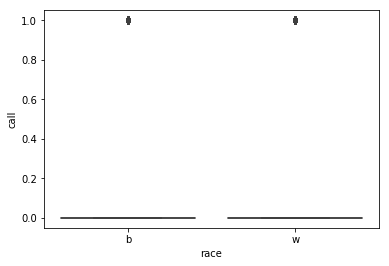

In [6]:
m_idx = list(bm_idx) + list(wm_idx)
_ = sns.boxplot(data.loc[m_idx,'race'], data.loc[m_idx,'call'])

In [43]:
vc_bf = data.loc[bf_idx,'call']
print('proportion of calls black women', np.mean(vc_bf))

vc_bm = data.loc[bm_idx,'call']
print('proportion of calls black men',np.mean(vc_bm))

vc_wf = data.loc[wf_idx,'call']
print('proportion of calls white women',np.mean(vc_wf))

vc_wm = data.loc[wm_idx,'call']
print('proportion of calls white men',np.mean(vc_wm))

proportion of calls black women 0.06627783924341202
proportion of calls black men 0.05828779563307762
proportion of calls white women 0.09892473369836807
proportion of calls white men 0.08869565278291702


Text(0.5,0,'race')

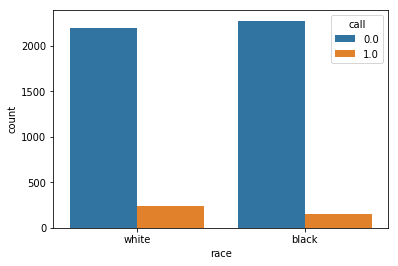

In [59]:
_  = sns.countplot(x="race", hue="call", data=data)
plt.xticks( np.arange(2), ('white','black'))
plt.xlabel('race')

### No differences between races other than callbacks
The graphs below are provided to show that the only real difference between the 2 groups is the mean/percentage of callbacks for each group. Most of the rest of the variables have identical distributions between the groups. 

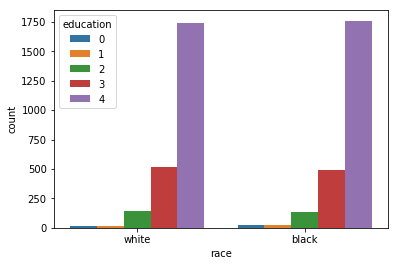

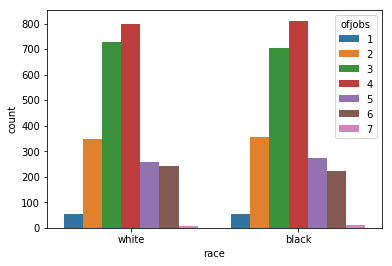

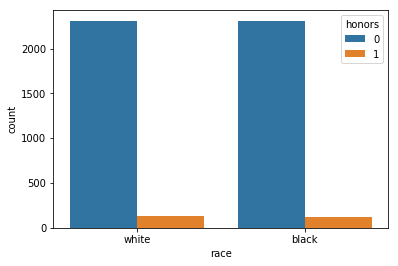

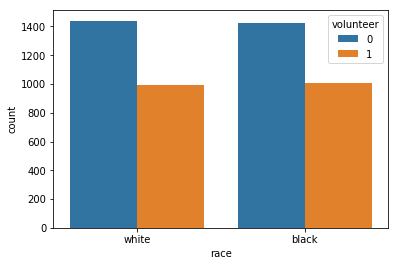

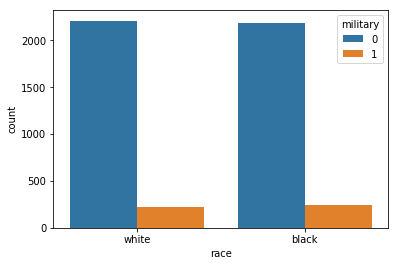

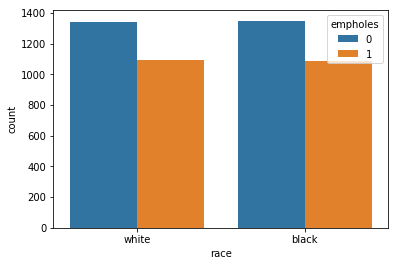

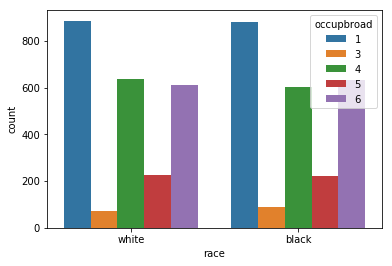

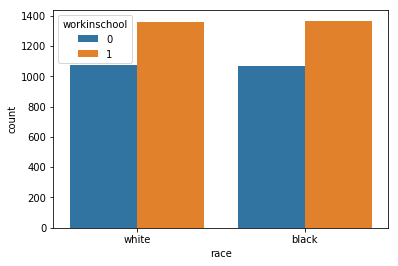

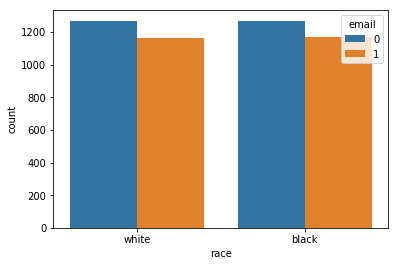

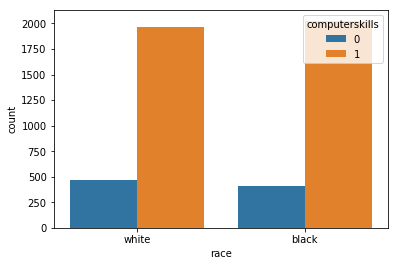

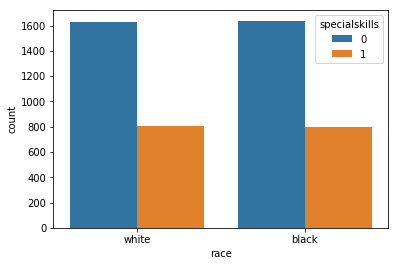

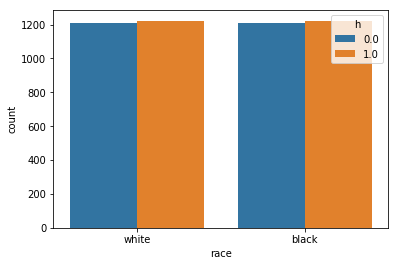

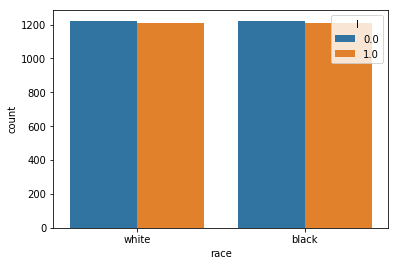

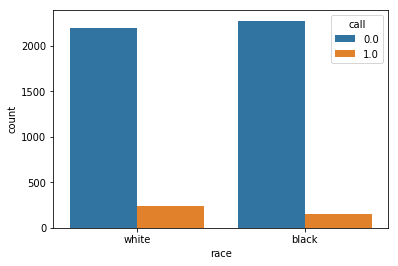

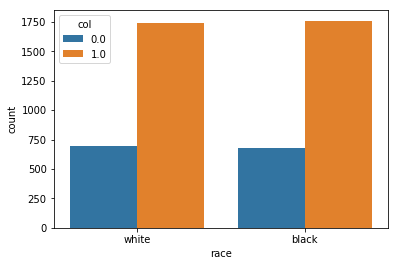

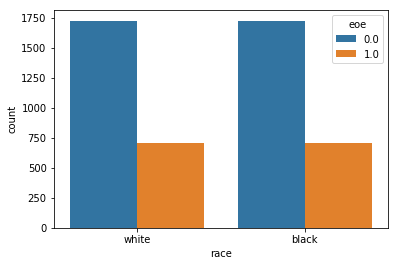

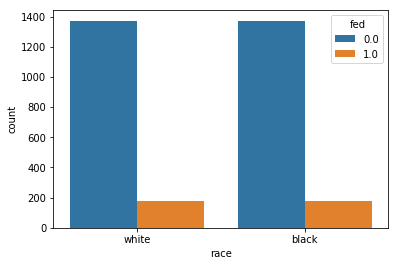

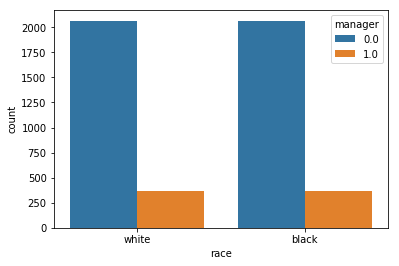

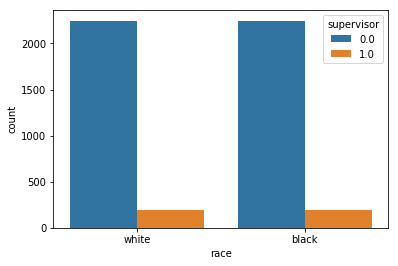

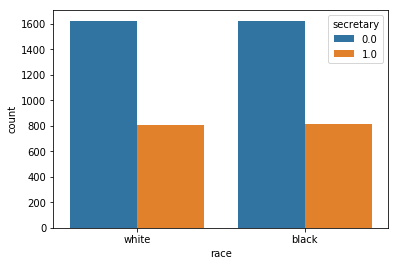

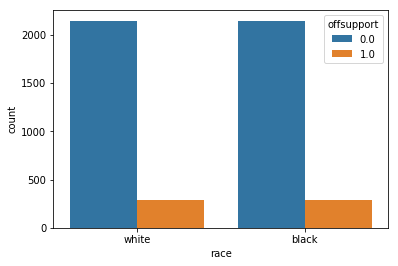

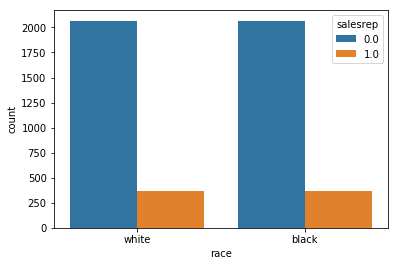

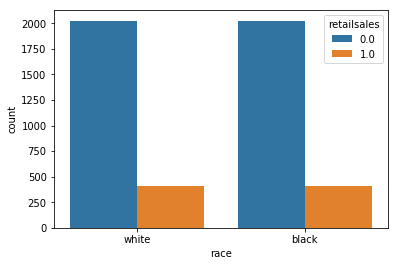

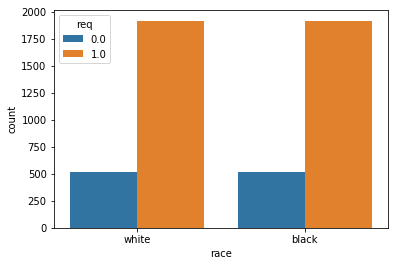

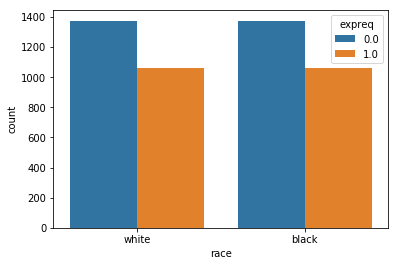

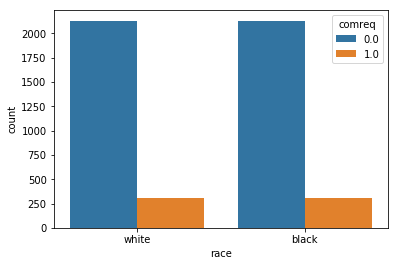

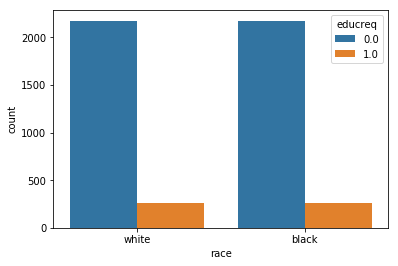

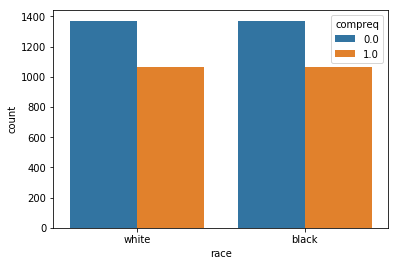

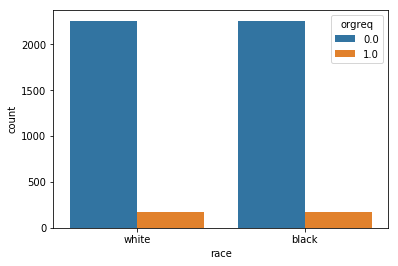

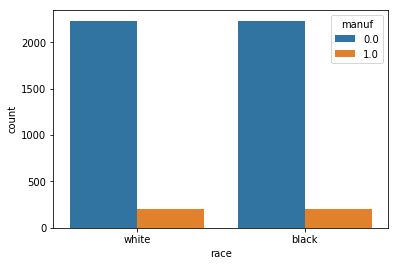

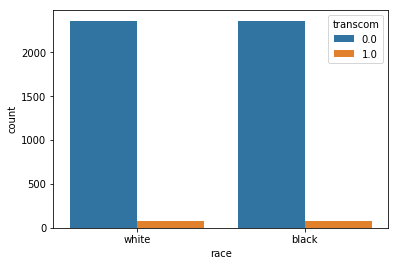

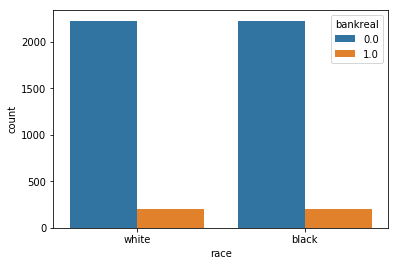

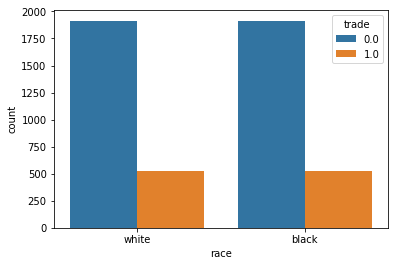

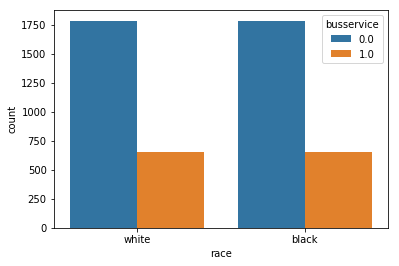

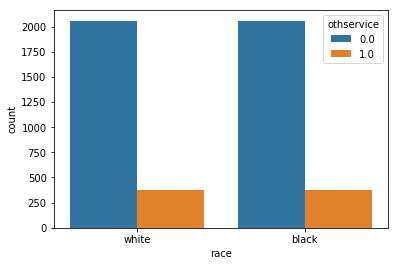

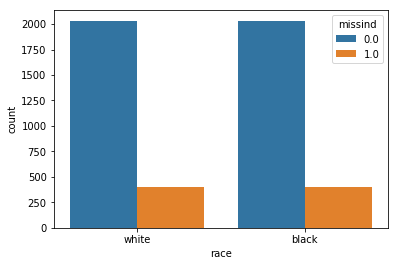

In [73]:
for col in data.columns:
    if col != 'race' and col not in skip:
        try:
            _  = sns.countplot(x="race", hue=col, data=data)
            plt.xticks( np.arange(2), ('white','black'))
            plt.xlabel('race')
            plt.show()
        except:
            skip.append(col)

In [79]:
print(data.fracblack.mean())
print(data.loc[data.race == 'w', 'fracblack'].mean())
print(data.loc[data.race == 'b', 'fracblack'].mean())

print(data.fracwhite.mean())
print(data.loc[data.race == 'w', 'fracwhite'].mean())
print(data.loc[data.race == 'b', 'fracwhite'].mean())

0.3108310401439667
0.30843982100486755
0.31321465969085693
0.5427716374397278
0.5452136993408203
0.5403302311897278


In [71]:
print(skip)

['id', 'ad', 'firstname', 'sex', 'city', 'kind', 'expminreq', 'schoolreq', 'ownership', 'id', 'ad', 'yearsexp', 'occupspecific', 'firstname', 'adid', 'fracblack', 'fracwhite', 'lmedhhinc', 'fracdropout', 'fraccolp', 'linc', 'expminreq', 'parent_sales', 'parent_emp', 'branch_sales', 'branch_emp', 'fracblack_empzip', 'fracwhite_empzip', 'lmedhhinc_empzip', 'fracdropout_empzip', 'fraccolp_empzip', 'linc_empzip']


In [12]:
# number of callbacks for black-sounding names
print(sum(data[data.race=='w'].call))
print(sum(data[data.race=='b'].call))

235.0
157.0


In [44]:
# counts by race
print(data.race.value_counts())

# counts by call
print(data.call.value_counts())

w    2435
b    2435
Name: race, dtype: int64
0.0    4478
1.0     392
Name: call, dtype: int64


In [48]:
# chi square stats show that the difference between races in number of calls for interviews is significant ...

b_arr = [157, 2278]
w_arr = [235,2200]
print(sum(b_arr))
print(sum(w_arr))
obs = np.array([b_arr,w_arr])
g, p, dof, expctd = stats.chi2_contingency(obs)
print('chi square: ', g)
print('p_value:', p)
print('degree of freedom: ',dof)
print(expctd)

2435
2435
chi square:  16.44902858418937
p_value: 4.997578389963255e-05
degree of freedom:  1
[[ 196. 2239.]
 [ 196. 2239.]]


In [16]:
print(data.shape[0])
data.columns

4870


Index(['id', 'ad', 'education', 'ofjobs', 'yearsexp', 'honors', 'volunteer',
       'military', 'empholes', 'occupspecific', 'occupbroad', 'workinschool',
       'email', 'computerskills', 'specialskills', 'firstname', 'sex', 'race',
       'h', 'l', 'call', 'city', 'kind', 'adid', 'fracblack', 'fracwhite',
       'lmedhhinc', 'fracdropout', 'fraccolp', 'linc', 'col', 'expminreq',
       'schoolreq', 'eoe', 'parent_sales', 'parent_emp', 'branch_sales',
       'branch_emp', 'fed', 'fracblack_empzip', 'fracwhite_empzip',
       'lmedhhinc_empzip', 'fracdropout_empzip', 'fraccolp_empzip',
       'linc_empzip', 'manager', 'supervisor', 'secretary', 'offsupport',
       'salesrep', 'retailsales', 'req', 'expreq', 'comreq', 'educreq',
       'compreq', 'orgreq', 'manuf', 'transcom', 'bankreal', 'trade',
       'busservice', 'othservice', 'missind', 'ownership'],
      dtype='object')

In [17]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


<div class="span5 alert alert-success">
<p>Your answers to Q1 and Q2 here</p>
</div>


### Question One:
The Central Limit Theorem will not apply in this instance because we are not dealing with continuous data. We are dealing with a binary outcome. Either the candidate was called for an interview or not. A chi-square test or a logistic regression are the appropriate tests to run. 

### Question Two:
**Null Hypothesis: That race is a factor in determining whether a candidate should be called for an interview after reviewing their resume.**

**Alternatie Hypothesis: That race is not a factor.**

In [18]:
w = data[data.race=='w']
b = data[data.race=='b']

### Bootstrap Hypothesis Testing
The p-value of the difference in the proportion of calls for black and white candidates for employment suggests that the difference is statistically significant according to the permutation tests that were executed. The bootstrap test for 10000 permutations returned a p-value of 0.0. The same test ran for 100,000 permutations returned a p-value of 0.00005. Both tests provide evidence to reject the null hypothesis at the alpha=0.05 level. 

Additionally, the 95% confidence interval of the difference in means does NOT include 0. This is more evidence that the difference in the proportion of calls to black and white candidates for employment is statistically significant and that the null hypothesis should be rejected.

In [37]:
# Your solution to Q3 here
data_b = data.loc[data.race == 'b', 'call']
data_w = data.loc[data.race == 'w', 'call']

# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(data_w, data_b)
print(empirical_diff_means)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(data_w, data_b,
                                 diff_of_means, size=100000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)

# Compute the difference of the sample means: mean_diff
mean_diff = np.mean(data_w) - np.mean(data_b)

print(np.mean(data_w))

# Get bootstrap replicates of means
bs_replicates_b = draw_bs_reps(data_b,np.mean,10000)
bs_replicates_w = draw_bs_reps(data_w,np.mean,10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_w - bs_replicates_b

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates,[2.5,97.5])

# Print the results
print('difference of proportions of calls =', mean_diff )
print('95% confidence interval =', conf_int, 'of proportion of calls')

0.03203285485506058
p-value = 6e-05
0.09650924056768417
difference of proportions of calls = 0.03203285485506058
95% confidence interval = [0.01683778 0.04722792] of proportion of calls


<div class="span5 alert alert-success">
<p> Your answers to Q4 and Q5 here </p>
</div>